# **(Crypto Currency Future Price Forecast Modelling)**

## Objectives

* Load my cleaned dataset.

Build 3 very simple models per coin:

Naive: tomorrow = today’s close

Moving Average (MA-7): tomorrow = mean of last 7 closes

Linear Regression (lags): predict next close from lagged closes + simple indicators

Backtest on the last 180 days (walk-forward) → report MAPE and RMSE.

Pick a best model per coin (lowest MAPE) and forecast +30 / +60 / +90 days.

Create a Buy/Hold/Sell indication per coin using MA trend + MACD + RSI.

Save small CSVs to Reports/ for Power BI and the presentation.





---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

# Section 1

Section 1 content

In [4]:
# Load libraries and data
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

df = pd.read_csv("C:\\Users\\Nine\\OneDrive\\Documents\\VS Code Projects\\Crypto-Currency-Future-Price-Forecast\\DataSet\\Cleaned\\crypto_clean.csv")
df.head()

print(df.head())

  Symbol        Date     Open     High      Low    Close  return_1d      ma_7  \
0    BTC  2010-07-17  0.04951  0.04951  0.04951  0.04951        NaN       NaN   
1    BTC  2010-07-18  0.04951  0.08585  0.04951  0.08584   0.733791       NaN   
2    BTC  2010-07-19  0.08584  0.09307  0.07723  0.08080  -0.058714  0.072050   
3    BTC  2010-07-20  0.08080  0.08181  0.07426  0.07474  -0.075000  0.072722   
4    BTC  2010-07-21  0.07474  0.07921  0.06634  0.07921   0.059807  0.074020   

   ma_30  rsi_14  macd_line  macd_signal  macd_hist  bb_ma20  bb_upper  \
0    NaN     NaN   0.000000     0.000000   0.000000      NaN       NaN   
1    NaN     NaN   0.002898     0.000580   0.002318      NaN       NaN   
2    NaN     NaN   0.004734     0.001410   0.003323      NaN       NaN   
3    NaN     NaN   0.005634     0.002255   0.003379      NaN       NaN   
4    NaN     NaN   0.006632     0.003131   0.003502      NaN       NaN   

   bb_lower  bb_width  atr_14  
0       NaN       NaN     NaN  
1   

---

# Section 2

In [5]:
# Backtest window: last N days
BACKTEST_DAYS = 180

# Moving Average window
MA_WINDOW = 7

# Forecast horizons (calendar days ahead)
HORIZONS = [30, 60, 90]

# Features used in Linear Regression (keep it modest & explainable)
LR_FEATURES = [
    "Close_lag1","Close_lag7","Close_lag14",  # lags of Close
    "ma_7","ma_30","rsi_14","macd_hist","atr_14"  # simple indicators from ETL
]


In [8]:
symbols = sorted(df["Symbol"].unique())
print("Coins:", symbols, "| rows:", len(df))

Coins: ['BTC', 'DOGE', 'ETH', 'HBAR', 'QNT', 'SOL', 'XDC', 'XLM', 'XRP'] | rows: 27898


In [9]:
def prepare_coin(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values("Date").copy()
    g["Close_lag1"]  = g["Close"].shift(1)
    g["Close_lag7"]  = g["Close"].shift(7)
    g["Close_lag14"] = g["Close"].shift(14)
    return g

coin_data = {sym: prepare_coin(df[df["Symbol"]==sym].copy()) for sym in symbols}

# sanity peek
first_sym = symbols[0]
coin_data[first_sym].tail(3)


,Symbol,Date,Open,High,Low,Close,return_1d,ma_7,ma_30,rsi_14,...,macd_signal,macd_hist,bb_ma20,bb_upper,bb_lower,bb_width,atr_14,Close_lag1,Close_lag7,Close_lag14
5518,BTC,2025-10-12,111015.6,115672.4,109681.0,114985.5,0.035760,118971.042857,116321.290000,55.812568,...,1500.214294,-720.950534,116586.335,127372.966809,105799.703191,0.185041,4868.907143,111015.6,122791.4,110889.0
5519,BTC,2025-10-13,114985.5,116050.8,113852.4,115804.1,0.007119,117632.628571,116315.560000,52.366400,...,1315.929986,-737.137231,116765.640,127364.108685,106167.171315,0.181534,4769.435714,114985.5,125173.0,114257.0
5520,BTC,2025-10-14,115804.3,115950.8,109956.9,113196.6,-0.022516,116360.514286,116217.613333,48.551510,...,1094.169379,-887.042429,116755.070,127368.049872,106142.090128,0.181799,5044.357143,115804.1,122101.4,114218.0


In [10]:
# Naive: next = last close
def predict_naive(history_close: pd.Series) -> float:
    return float(history_close.iloc[-1])

# Moving Average: next = mean of last N closes
MA_WINDOW = 7  # change to 14 if you prefer smoother
def predict_ma(history_close: pd.Series, window: int = MA_WINDOW) -> float:
    recent = history_close.tail(window).dropna()
    return float(recent.mean()) if len(recent) else float(history_close.iloc[-1])

---

In [11]:
from sklearn.linear_model import LinearRegression

LR_FEATURES = [
    "Close_lag1","Close_lag7","Close_lag14",
    "ma_7","ma_30","rsi_14","macd_hist","atr_14"
]

def one_step_lr_forecast(train_df: pd.DataFrame) -> float:
    """
    Train LR on all rows with non-null features and predict the next day's Close.
    Fallback to MA if too little data.
    """
    data = train_df.dropna(subset=LR_FEATURES + ["Close"]).copy()
    if len(data) < 30:
        return predict_ma(train_df["Close"], window=MA_WINDOW)
    X = data[LR_FEATURES]; y = data["Close"]
    model = LinearRegression().fit(X, y)
    last_row = data.iloc[-1:][LR_FEATURES]
    return float(model.predict(last_row)[0])

In [12]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

BACKTEST_DAYS = 180

def backtest_coin(g: pd.DataFrame, back_days: int = BACKTEST_DAYS) -> pd.DataFrame:
    g = g.sort_values("Date").reset_index(drop=True).copy()

    # make sure required features exist (compute if absent)
    if "ma_7" not in g.columns:
        g["ma_7"] = g["Close"].rolling(7, min_periods=3).mean()
    if "ma_30" not in g.columns:
        g["ma_30"] = g["Close"].rolling(30, min_periods=10).mean()
    if "macd_hist" not in g.columns:
        g["macd_hist"] = np.nan
    if "atr_14" not in g.columns:
        g["atr_14"] = np.nan

    start_idx = max(30, len(g) - back_days)  # ensure some history
    rows = []
    for i in range(start_idx, len(g)):
        train = g.iloc[:i].copy()
        # recompute lags for the training subset
        train["Close_lag1"]  = train["Close"].shift(1)
        train["Close_lag7"]  = train["Close"].shift(7)
        train["Close_lag14"] = train["Close"].shift(14)

        actual = g.iloc[i]["Close"]
        p_naive = predict_naive(train["Close"])
        p_ma    = predict_ma(train["Close"], window=MA_WINDOW)
        p_lr    = one_step_lr_forecast(train)

        rows.append({"Date": g.iloc[i]["Date"], "actual": actual,
                     "naive": p_naive, "ma": p_ma, "lr": p_lr})
    return pd.DataFrame(rows)

def metrics_table(bt: pd.DataFrame) -> pd.DataFrame:
    y = bt["actual"].values
    eps = 1e-9
    rows = []
    for m in ["naive","ma","lr"]:
        yhat = bt[m].values
        mape = mean_absolute_percentage_error(y + eps, yhat + eps)
        rmse = mean_squared_error(y, yhat, squared=False)
        rows.append({"Model": m.upper(), "MAPE": round(mape,4), "RMSE": round(rmse,4)})
    return pd.DataFrame(rows).sort_values("MAPE")

In [13]:
# Run backtests for all coins and save performance to Reports/
REPORTS = Path("Reports"); REPORTS.mkdir(exist_ok=True)

all_bt = {}
perf_rows = []
for sym in symbols:
    bt = backtest_coin(coin_data[sym], BACKTEST_DAYS)
    all_bt[sym] = bt
    mt = metrics_table(bt)
    mt.insert(0, "Symbol", sym)
    perf_rows.append(mt)

perf_df = pd.concat(perf_rows, ignore_index=True)
perf_df.to_csv(REPORTS / "model_performance.csv", index=False)
perf_df

,Symbol,Model,MAPE,RMSE
0,BTC,NAIVE,0.0128,1913.9633
1,BTC,LR,0.0173,2533.1579
2,BTC,MA,0.0229,3260.6780
3,DOGE,NAIVE,0.0356,0.0108
4,DOGE,LR,0.0477,0.0141
5,DOGE,MA,0.0620,0.0182
6,ETH,NAIVE,0.0273,131.6287
7,ETH,LR,0.0373,171.6383
8,ETH,MA,0.0465,217.3443
9,HBAR,NAIVE,0.0332,0.0096


In [16]:
from pathlib import Path

# Use the folder you actually have
REPORTS = Path("reports")  # <-- lowercase to match your directory
REPORTS.mkdir(parents=True, exist_ok=True)

print("Saving to:", REPORTS.resolve())

# If perf_df already exists in memory, (re)save it into the correct folder:
try:
    perf_df.to_csv(REPORTS / "model_performance.csv", index=False)
    print("OK ->", (REPORTS / "model_performance.csv").resolve())
except NameError:
    print("Note: perf_df isn't in memory. If needed, re-run the backtest cell first.")


Saving to: C:\Users\Nine\OneDrive\Documents\VS Code Projects\Crypto-Currency-Future-Price-Forecast\jupyter_notebooks\reports
OK -> C:\Users\Nine\OneDrive\Documents\VS Code Projects\Crypto-Currency-Future-Price-Forecast\jupyter_notebooks\reports\model_performance.csv


In [17]:
best_by_coin = (perf_df.sort_values(["Symbol","MAPE"])
                        .groupby("Symbol").head(1)
                        .reset_index(drop=True))
best_by_coin.to_csv(REPORTS / "model_best_per_coin.csv", index=False)
best_by_coin

,Symbol,Model,MAPE,RMSE
0,BTC,NAIVE,0.0128,1913.9633
1,DOGE,NAIVE,0.0356,0.0108
2,ETH,NAIVE,0.0273,131.6287
3,HBAR,NAIVE,0.0332,0.0096
4,QNT,NAIVE,0.0280,3.7995
5,SOL,NAIVE,0.0286,6.9188
6,XDC,NAIVE,0.0246,0.0028
7,XLM,NAIVE,0.0298,0.0160
8,XRP,NAIVE,0.0251,0.0981


In [20]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

REPORTS = Path("reports")
REPORTS.mkdir(exist_ok=True)

def future_dates(last_date: pd.Timestamp, horizon: int):
    return pd.date_range(last_date + pd.Timedelta(days=1), periods=horizon, freq="D")

def forecast_best(g: pd.DataFrame, best_model: str, horizons=(30,60,90)) -> pd.DataFrame:
    # Robust: ensure Date is datetime every time
    g = g.copy()
    g["Date"] = pd.to_datetime(g["Date"], errors="coerce")
    g = g.sort_values("Date").reset_index(drop=True)

    last_date = g["Date"].iloc[-1]
    rows = []

    if best_model in ["NAIVE","MA"]:
        const = predict_naive(g["Close"]) if best_model=="NAIVE" else predict_ma(g["Close"], window=MA_WINDOW)
        for H in horizons:
            for d in future_dates(last_date, H):
                rows.append({"Date": d, "Model": best_model, "H": H, "PredictedClose": const})
        return pd.DataFrame(rows)

    # LR recursive 1-step ahead
    sim = g.copy()
    for step in range(1, max(horizons)+1):
        sim["Close_lag1"]  = sim["Close"].shift(1)
        sim["Close_lag7"]  = sim["Close"].shift(7)
        sim["Close_lag14"] = sim["Close"].shift(14)
        sim["ma_7"]  = sim["Close"].rolling(7,  min_periods=3).mean()
        sim["ma_30"] = sim["Close"].rolling(30, min_periods=10).mean()
        if "macd_hist" not in sim: sim["macd_hist"] = np.nan
        if "atr_14"  not in sim:   sim["atr_14"]  = np.nan

        train = sim.dropna(subset=LR_FEATURES + ["Close"]).copy()
        if len(train) < 30:
            pred_next = predict_ma(sim["Close"], window=MA_WINDOW)
        else:
            X = train[LR_FEATURES]; y = train["Close"]
            lr = LinearRegression().fit(X, y)
            last_feats = train.iloc[-1:][LR_FEATURES]
            pred_next = float(lr.predict(last_feats)[0])

        next_date = sim["Date"].iloc[-1] + pd.Timedelta(days=1)
        new_row = sim.iloc[-1:].copy()
        new_row["Date"] = next_date
        new_row["Close"] = pred_next
        sim = pd.concat([sim, new_row], ignore_index=True)

        if step in horizons:
            rows.append({"Date": next_date, "Model": "LR", "H": step, "PredictedClose": pred_next})

    return pd.DataFrame(rows)


In [21]:
best_fc_all = []
for _, r in best_by_coin.iterrows():
    sym = r["Symbol"]; mdl = r["Model"]
    fc = forecast_best(coin_data[sym], mdl, horizons=(30,60,90))
    fc.insert(0, "Symbol", sym)
    best_fc_all.append(fc)

forecast_best_df = pd.concat(best_fc_all, ignore_index=True)
forecast_best_df.to_csv(REPORTS / "model_best_forecast.csv", index=False)
print("Saved ->", (REPORTS / "model_best_forecast.csv").resolve())
forecast_best_df.head()


Saved -> C:\Users\Nine\OneDrive\Documents\VS Code Projects\Crypto-Currency-Future-Price-Forecast\jupyter_notebooks\reports\model_best_forecast.csv


,Symbol,Date,Model,H,PredictedClose
0,BTC,2025-10-15,NAIVE,30,113196.6
1,BTC,2025-10-16,NAIVE,30,113196.6
2,BTC,2025-10-17,NAIVE,30,113196.6
3,BTC,2025-10-18,NAIVE,30,113196.6
4,BTC,2025-10-19,NAIVE,30,113196.6


In [22]:
from pathlib import Path
import numpy as np
import pandas as pd

REPORTS = Path("reports"); REPORTS.mkdir(exist_ok=True)

# ensure Date is datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

latest = (df.sort_values(["Symbol","Date"])
            .groupby("Symbol").tail(1).reset_index(drop=True))

latest["trend_up"] = latest["ma_7"] > latest["ma_30"]
latest["macd_pos"] = latest["macd_line"] > latest["macd_signal"]

buy  = latest["trend_up"] & latest["macd_pos"] & (latest["rsi_14"] < 60)
sell = (~latest["trend_up"]) & (~latest["macd_pos"]) & (latest["rsi_14"] > 40)
latest["indication"] = np.select([buy, sell], ["BUY","SELL"], default="HOLD")

signals_latest = latest[["Symbol","Date","Close","ma_7","ma_30","rsi_14","macd_line","macd_signal","indication"]]
signals_latest.to_csv(REPORTS / "signals_latest.csv", index=False)
print("Saved ->", (REPORTS / "signals_latest.csv").resolve())
signals_latest


Saved -> C:\Users\Nine\OneDrive\Documents\VS Code Projects\Crypto-Currency-Future-Price-Forecast\jupyter_notebooks\reports\signals_latest.csv


,Symbol,Date,Close,ma_7,ma_30,rsi_14,macd_line,macd_signal,indication
0,BTC,2025-10-14,113196.600000,116360.514286,116217.613333,48.551510,207.126950,1094.169379,HOLD
1,DOGE,2025-10-14,0.203692,0.214987,0.243295,42.942782,-0.010099,-0.004658,SELL
2,ETH,2025-10-14,4120.361000,4161.532429,4305.003700,49.254076,-52.798346,-23.064990,SELL
3,HBAR,2025-10-14,0.188223,0.189973,0.217411,40.498780,-0.011314,-0.008276,SELL
4,QNT,2025-10-14,89.724840,93.250864,98.301562,35.787155,-2.500649,-1.206625,HOLD
5,SOL,2025-10-14,201.350700,203.800900,219.527010,47.036943,-4.741334,-1.780827,SELL
6,XDC,2025-10-14,0.060637,0.065003,0.072856,29.709337,-0.003828,-0.002509,HOLD
7,XLM,2025-10-14,0.336802,0.345948,0.373930,44.441987,-0.010889,-0.005579,SELL
8,XRP,2025-10-14,2.496800,2.584217,2.855237,37.594345,-0.109110,-0.066034,HOLD


In [23]:
cutoff = df["Date"].max() - pd.Timedelta(days=365)
year_df = df[df["Date"] >= cutoff].copy()

def add_indication_block(g: pd.DataFrame) -> pd.DataFrame:
    g = g.copy()
    g["trend_up"] = g["ma_7"] > g["ma_30"]
    g["macd_pos"] = g["macd_line"] > g["macd_signal"]
    buy  = g["trend_up"] & g["macd_pos"] & (g["rsi_14"] < 60)
    sell = (~g["trend_up"]) & (~g["macd_pos"]) & (g["rsi_14"] > 40)
    g["indication"] = np.select([buy, sell], ["BUY","SELL"], default="HOLD")
    return g

daily_signals = (year_df.groupby("Symbol", group_keys=False)
                        .apply(add_indication_block)
                        .reset_index(drop=True))[["Symbol","Date","indication"]]
daily_signals.to_csv(REPORTS / "signals_daily_365d.csv", index=False)
print("Saved ->", (REPORTS / "signals_daily_365d.csv").resolve(), "| rows:", len(daily_signals))


Saved -> C:\Users\Nine\OneDrive\Documents\VS Code Projects\Crypto-Currency-Future-Price-Forecast\jupyter_notebooks\reports\signals_daily_365d.csv | rows: 2862


In [24]:
# latest close per coin
last_close = df.sort_values(["Symbol","Date"]).groupby("Symbol").tail(1)[["Symbol","Close"]]

# take the +30d point from the best-model forecasts (built in Section 8)
fc30 = forecast_best_df[forecast_best_df["H"]==30].copy()
fc30_latest = fc30.sort_values(["Symbol","Date"]).groupby("Symbol").tail(1)[["Symbol","PredictedClose"]]

direction = last_close.merge(fc30_latest, on="Symbol", how="left")
direction["exp_change_30d_%"] = (direction["PredictedClose"] - direction["Close"]) / direction["Close"] * 100
direction = direction.sort_values("Symbol")
direction.to_csv(REPORTS / "model_direction_30d.csv", index=False)
print("Saved ->", (REPORTS / "model_direction_30d.csv").resolve())
direction


Saved -> C:\Users\Nine\OneDrive\Documents\VS Code Projects\Crypto-Currency-Future-Price-Forecast\jupyter_notebooks\reports\model_direction_30d.csv


,Symbol,Close,PredictedClose,exp_change_30d_%
0,BTC,113196.600000,113196.600000,0.0
1,DOGE,0.203692,0.203692,0.0
2,ETH,4120.361000,4120.361000,0.0
3,HBAR,0.188223,0.188223,0.0
4,QNT,89.724840,89.724840,0.0
5,SOL,201.350700,201.350700,0.0
6,XDC,0.060637,0.060637,0.0
7,XLM,0.336802,0.336802,0.0
8,XRP,2.496800,2.496800,0.0


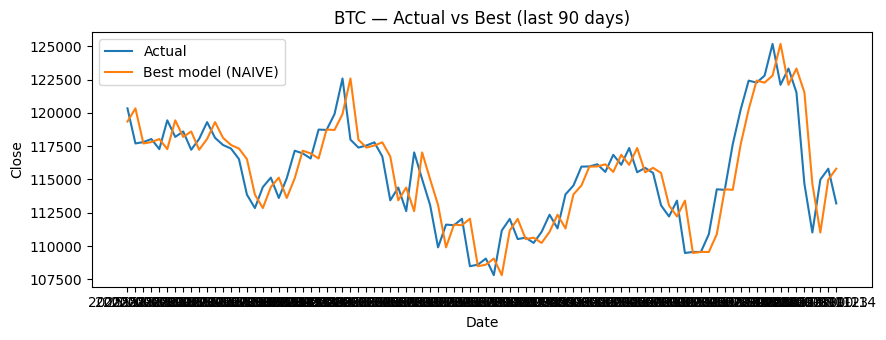

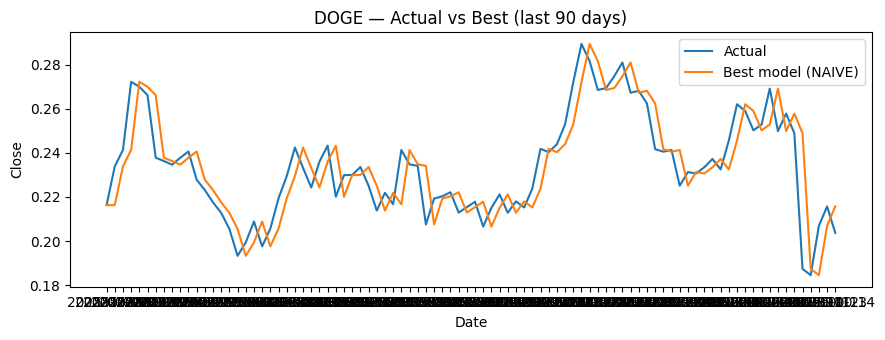

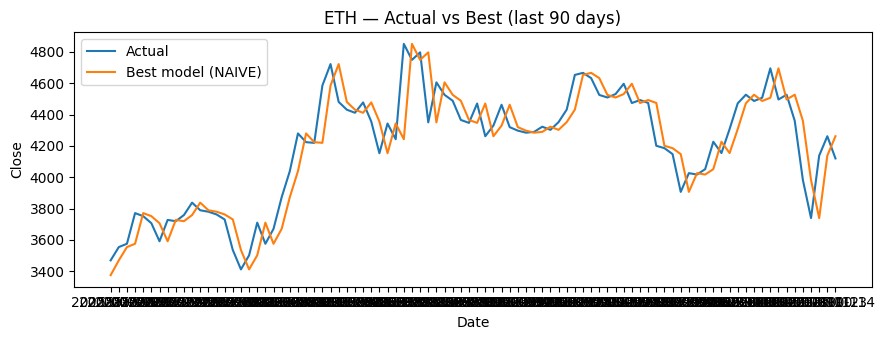

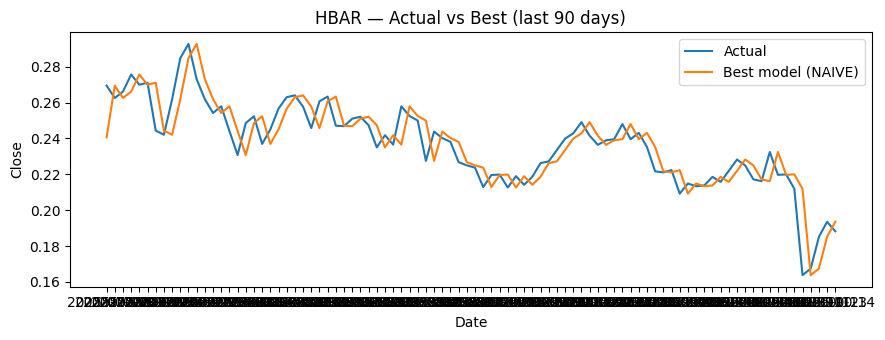

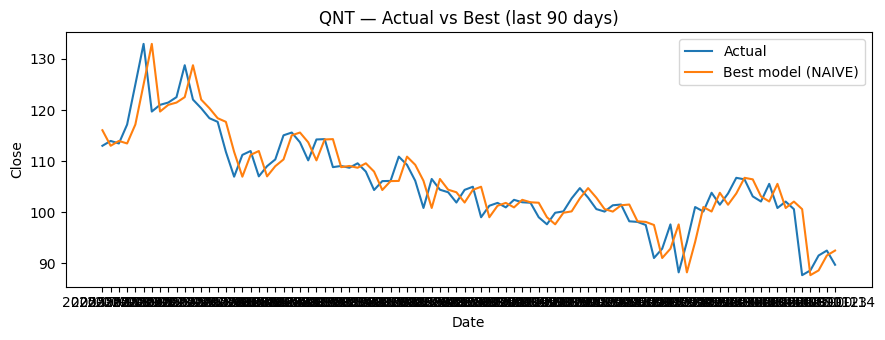

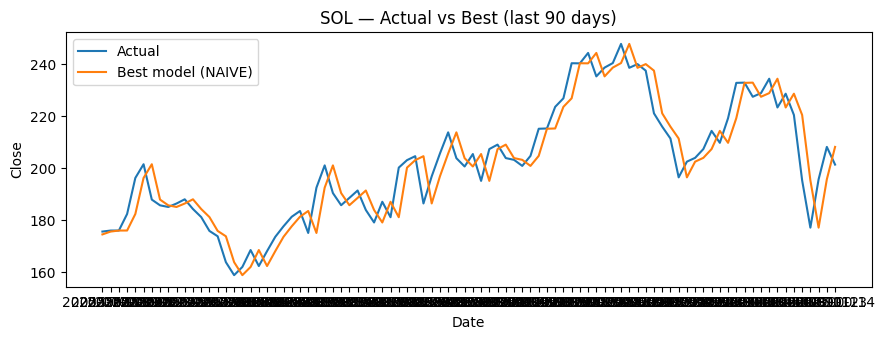

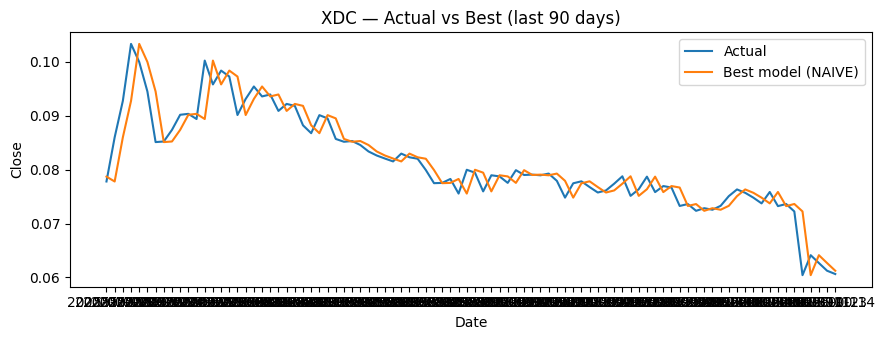

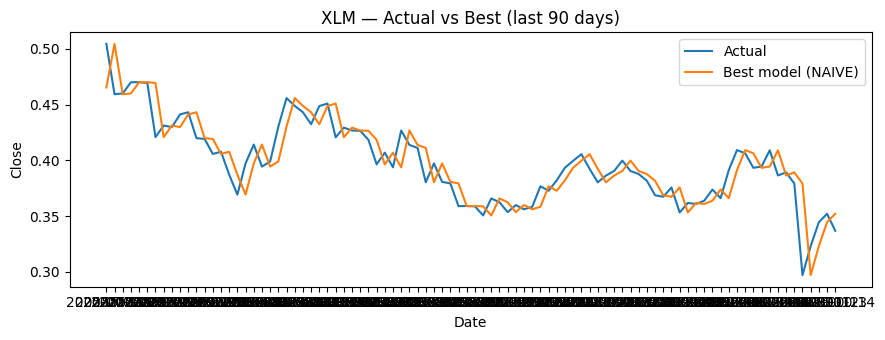

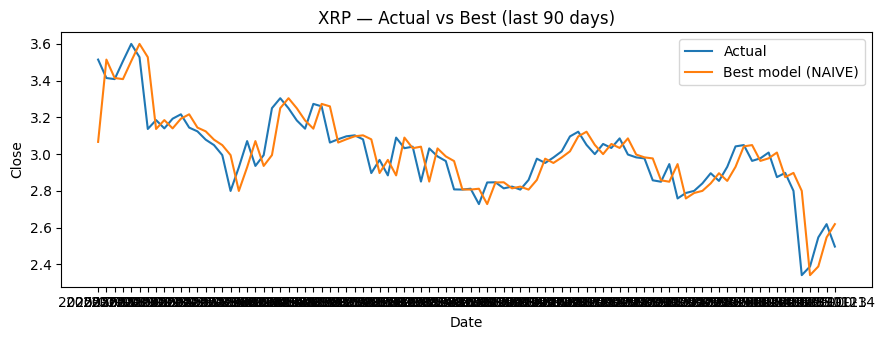

In [25]:
import matplotlib.pyplot as plt

for sym in symbols:
    bt = all_bt[sym]
    best = best_by_coin[best_by_coin["Symbol"]==sym]["Model"].iloc[0].lower()
    show = bt.tail(90).copy()  # last 90 backtest days

    plt.figure(figsize=(9,3.5))
    plt.plot(show["Date"], show["actual"], label="Actual")
    plt.plot(show["Date"], show[best], label=f"Best model ({best.upper()})")
    plt.title(f"{sym} — Actual vs Best (last 90 days)")
    plt.xlabel("Date"); plt.ylabel("Close"); plt.legend()
    plt.tight_layout()
    plt.show()


---

In [ ]:
# Buy, Sell Hold signals - latest

signals_latest = pd.read_csv("reports/signals_latest.csv")
signals_latest

,Symbol,Date,Close,ma_7,ma_30,rsi_14,macd_line,macd_signal,indication
0,BTC,2025-10-14,113196.600000,116360.514286,116217.613333,48.551510,207.126950,1094.169379,HOLD
1,DOGE,2025-10-14,0.203692,0.214987,0.243295,42.942782,-0.010099,-0.004658,SELL
2,ETH,2025-10-14,4120.361000,4161.532429,4305.003700,49.254076,-52.798346,-23.064990,SELL
3,HBAR,2025-10-14,0.188223,0.189973,0.217411,40.498780,-0.011314,-0.008276,SELL
4,QNT,2025-10-14,89.724840,93.250864,98.301562,35.787155,-2.500649,-1.206625,HOLD
5,SOL,2025-10-14,201.350700,203.800900,219.527010,47.036943,-4.741334,-1.780827,SELL
6,XDC,2025-10-14,0.060637,0.065003,0.072856,29.709337,-0.003828,-0.002509,HOLD
7,XLM,2025-10-14,0.336802,0.345948,0.373930,44.441987,-0.010889,-0.005579,SELL
8,XRP,2025-10-14,2.496800,2.584217,2.855237,37.594345,-0.109110,-0.066034,HOLD


In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from pathlib import Path

REPORTS = Path("reports"); REPORTS.mkdir(exist_ok=True)

# Reuse LR features and a helper to get an LR forecast (30d) per coin
LR_FEATURES = [
    "Close_lag1","Close_lag7","Close_lag14",
    "ma_7","ma_30","rsi_14","macd_hist","atr_14"
]

def lr_30d_forecast_price(g: pd.DataFrame) -> float:
    """Recursive 1-step LR forecast out to +30d; return the +30d price."""
    sim = g.copy()
    sim["Date"] = pd.to_datetime(sim["Date"], errors="coerce")
    sim = sim.sort_values("Date").reset_index(drop=True)

    for step in range(1, 31):
        # recompute features
        sim["Close_lag1"]  = sim["Close"].shift(1)
        sim["Close_lag7"]  = sim["Close"].shift(7)
        sim["Close_lag14"] = sim["Close"].shift(14)
        sim["ma_7"]  = sim["Close"].rolling(7,  min_periods=3).mean()
        sim["ma_30"] = sim["Close"].rolling(30, min_periods=10).mean()
        if "macd_hist" not in sim: sim["macd_hist"] = np.nan
        if "atr_14"  not in sim:   sim["atr_14"]  = np.nan

        train = sim.dropna(subset=LR_FEATURES + ["Close"]).copy()
        if len(train) < 30:
            # fallback: simple MA if we don't have enough rows
            pred_next = float(sim["Close"].tail(7).mean())
        else:
            X = train[LR_FEATURES]; y = train["Close"]
            lr = LinearRegression().fit(X, y)
            pred_next = float(lr.predict(train.iloc[-1:][LR_FEATURES])[0])

        next_date = sim["Date"].iloc[-1] + pd.Timedelta(days=1)
        add = sim.iloc[-1:].copy()
        add["Date"] = next_date
        add["Close"] = pred_next
        sim = pd.concat([sim, add], ignore_index=True)

    return float(sim["Close"].iloc[-1])  # the +30d price

# Build direction table using LR for direction (even if best model is NAIVE/MA)
rows = []
for sym in sorted(df["Symbol"].unique()):
    g = df[df["Symbol"]==sym].copy()
    g["Date"] = pd.to_datetime(g["Date"], errors="coerce")
    g = g.sort_values("Date")
    last_close = float(g["Close"].iloc[-1])
    p30 = lr_30d_forecast_price(g[["Date","Close","ma_7","ma_30","rsi_14","macd_hist","atr_14"]].copy())
    change_pct = (p30 - last_close) / last_close * 100.0
    rows.append({"Symbol": sym, "Close": last_close, "PredictedClose": p30, "exp_change_30d_%": change_pct})

direction_lr = pd.DataFrame(rows).sort_values("Symbol").reset_index(drop=True)
direction_lr.to_csv(REPORTS / "model_direction_30d.csv", index=False)  # overwrite the earlier constant version
print("Saved ->", (REPORTS / "model_direction_30d.csv").resolve())
direction_lr


Saved -> C:\Users\Nine\OneDrive\Documents\VS Code Projects\Crypto-Currency-Future-Price-Forecast\jupyter_notebooks\reports\model_direction_30d.csv


,Symbol,Close,PredictedClose,exp_change_30d_%
0,BTC,113196.600000,103710.603686,-8.380107
1,DOGE,0.203692,0.131310,-35.535227
2,ETH,4120.361000,3822.558951,-7.227572
3,HBAR,0.188223,0.138159,-26.598163
4,QNT,89.724840,63.177842,-29.587123
5,SOL,201.350700,164.157511,-18.471845
6,XDC,0.060637,0.038249,-36.921593
7,XLM,0.336802,0.269299,-20.042433
8,XRP,2.496800,1.973332,-20.965540


In [32]:
import pandas as pd
import numpy as np

# Make sure we have the forecasts table from Section 8
best_fc = pd.read_csv("reports/model_best_forecast.csv", parse_dates=["Date"])

# Latest close (day 0) per coin
last_close = (df.sort_values(["Symbol","Date"])
                .groupby("Symbol").tail(1)[["Symbol","Close"]]
                .rename(columns={"Close":"Close_day0"}))

# Get +30/+60/+90 from the best model
wide = (best_fc.pivot_table(index="Symbol", columns="H", values="PredictedClose", aggfunc="last")
             .rename(columns={30:"Pred_day30",60:"Pred_day60",90:"Pred_day90"})
             .reset_index())

summary_best = last_close.merge(wide, on="Symbol", how="left")

# % changes vs day0
for h in (30,60,90):
    summary_best[f"Change_{h}d_%"] = (summary_best[f"Pred_day{h}"] - summary_best["Close_day0"]) / summary_best["Close_day0"] * 100

summary_best = summary_best.sort_values("Symbol").reset_index(drop=True)
summary_best


,Symbol,Close_day0,Pred_day30,Pred_day60,Pred_day90,Change_30d_%,Change_60d_%,Change_90d_%
0,BTC,113196.600000,113196.600000,113196.600000,113196.600000,0.0,0.0,0.0
1,DOGE,0.203692,0.203692,0.203692,0.203692,0.0,0.0,0.0
2,ETH,4120.361000,4120.361000,4120.361000,4120.361000,0.0,0.0,0.0
3,HBAR,0.188223,0.188223,0.188223,0.188223,0.0,0.0,0.0
4,QNT,89.724840,89.724840,89.724840,89.724840,0.0,0.0,0.0
5,SOL,201.350700,201.350700,201.350700,201.350700,0.0,0.0,0.0
6,XDC,0.060637,0.060637,0.060637,0.060637,0.0,0.0,0.0
7,XLM,0.336802,0.336802,0.336802,0.336802,0.0,0.0,0.0
8,XRP,2.496800,2.496800,2.496800,2.496800,0.0,0.0,0.0


In [33]:
from sklearn.linear_model import LinearRegression

LR_FEATURES = [
    "Close_lag1","Close_lag7","Close_lag14",
    "ma_7","ma_30","rsi_14","macd_hist","atr_14"
]

def lr_forecast_horizons(g: pd.DataFrame, horizons=(30,60,90)):
    g = g.copy()
    g["Date"] = pd.to_datetime(g["Date"], errors="coerce")
    g = g.sort_values("Date").reset_index(drop=True)

    last_close = float(g["Close"].iloc[-1])
    preds = {}
    sim = g.copy()

    for step in range(1, max(horizons)+1):
        # minimal features recomputed each step
        sim["Close_lag1"]  = sim["Close"].shift(1)
        sim["Close_lag7"]  = sim["Close"].shift(7)
        sim["Close_lag14"] = sim["Close"].shift(14)
        sim["ma_7"]  = sim["Close"].rolling(7,  min_periods=3).mean()
        sim["ma_30"] = sim["Close"].rolling(30, min_periods=10).mean()
        if "macd_hist" not in sim: sim["macd_hist"] = np.nan
        if "atr_14"  not in sim:   sim["atr_14"]  = np.nan

        train = sim.dropna(subset=LR_FEATURES + ["Close"]).copy()
        if len(train) < 30:
            pred_next = float(sim["Close"].tail(7).mean())
        else:
            X = train[LR_FEATURES]; y = train["Close"]
            lr = LinearRegression().fit(X, y)
            pred_next = float(lr.predict(train.iloc[-1:][LR_FEATURES])[0])

        next_date = sim["Date"].iloc[-1] + pd.Timedelta(days=1)
        add = sim.iloc[-1:].copy()
        add["Date"] = next_date
        add["Close"] = pred_next
        sim = pd.concat([sim, add], ignore_index=True)

        if step in horizons:
            preds[step] = pred_next

    return last_close, preds

# Build LR summary for ALL coins
rows = []
for sym in sorted(df["Symbol"].unique()):
    g = df[df["Symbol"]==sym][["Date","Close","ma_7","ma_30","rsi_14","macd_hist","atr_14"]].copy()
    day0, ph = lr_forecast_horizons(g, horizons=(30,60,90))
    rows.append({
        "Symbol": sym,
        "Close_day0": day0,
        "Pred_day30": ph.get(30, np.nan),
        "Pred_day60": ph.get(60, np.nan),
        "Pred_day90": ph.get(90, np.nan),
    })

summary_lr = pd.DataFrame(rows).sort_values("Symbol").reset_index(drop=True)
for h in (30,60,90):
    summary_lr[f"Change_{h}d_%"] = (summary_lr[f"Pred_day{h}"] - summary_lr["Close_day0"]) / summary_lr["Close_day0"] * 100

summary_lr


,Symbol,Close_day0,Pred_day30,Pred_day60,Pred_day90,Change_30d_%,Change_60d_%,Change_90d_%
0,BTC,113196.600000,103710.603686,91221.569720,79165.696785,-8.380107,-19.413154,-30.063538
1,DOGE,0.203692,0.131310,0.063408,0.006642,-35.535227,-68.870513,-96.739306
2,ETH,4120.361000,3822.558951,3433.471719,3055.589585,-7.227572,-16.670609,-25.841702
3,HBAR,0.188223,0.138159,0.090471,0.046563,-26.598163,-51.934294,-75.261669
4,QNT,89.724840,63.177842,35.026538,8.220868,-29.587123,-60.962274,-90.837690
5,SOL,201.350700,164.157511,125.689407,90.325667,-18.471845,-37.576871,-55.140128
6,XDC,0.060637,0.038249,0.017235,-0.000548,-36.921593,-71.577713,-100.903259
7,XLM,0.336802,0.269299,0.199712,0.137234,-20.042433,-40.703462,-59.253788
8,XRP,2.496800,1.973332,1.414767,0.897805,-20.965540,-43.336779,-64.041762


In [34]:
def to_long(summary_df, model_name="LR"):
    long_rows = []
    for _, r in summary_df.iterrows():
        sym = r["Symbol"]
        long_rows.append({"Symbol": sym, "H": 0,  "Price": r["Close_day0"], "Model": model_name})
        for H in (30,60,90):
            long_rows.append({"Symbol": sym, "H": H, "Price": r[f"Pred_day{H}"], "Model": model_name})
    return pd.DataFrame(long_rows).sort_values(["Symbol","H"]).reset_index(drop=True)

long_lr = to_long(summary_lr, model_name="LR")          # non-constant
long_best = to_long(summary_best, model_name="BEST")    # may be constant per coin

# See all coins stacked for H=0/30/60/90
long_lr


,Symbol,H,Price,Model
0,BTC,0,113196.600000,LR
1,BTC,30,103710.603686,LR
2,BTC,60,91221.569720,LR
3,BTC,90,79165.696785,LR
4,DOGE,0,0.203692,LR
5,DOGE,30,0.131310,LR
6,DOGE,60,0.063408,LR
7,DOGE,90,0.006642,LR
8,ETH,0,4120.361000,LR
9,ETH,30,3822.558951,LR
